## GLS map-making for Q and U components using the dedicated wrapper function

This example illustrates the GLS map-making for Q and U components using dedicated wrapper function for the same.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import healpy as hp
import brahmap

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
### Random number generator
seed = 456
rng = np.random.default_rng(seed=seed)

### Producing the input maps, pointings and TOD

In [3]:
### Simulation parameters

# Numerical precisions
dtype_int = np.int32  # Numerical precision for pointing indices
dtype_float = np.float64  # Numerical precision for TOD and output maps

# Healpix map parameter
nside = 16
npix = hp.nside2npix(nside)

# Number of samples
nsamples = npix * 6

# Number of bad samples
nbad_samples = npix

In [4]:
### Generating random pointing indices
pointings = rng.integers(low=0, high=npix, size=nsamples, dtype=dtype_int)

### Generating pointing flags
# Samples marked with flag `False` are considered as the bad samples and are excluded from map-making
pointings_flag = np.ones(nsamples, dtype=bool)
bad_samples = rng.integers(low=0, high=nsamples, size=nbad_samples)
pointings_flag[bad_samples] = False

# Generating the detector polarization angles
pol_angles = rng.uniform(low=-np.pi / 2.0, high=np.pi / 2.0, size=nsamples).astype(
    dtype=dtype_float
)

In [5]:
### Generating random input maps
input_maps = np.empty((2, npix), dtype=dtype_float)
input_maps[0] = rng.uniform(low=-10.0, high=10.0, size=npix)  # input Q map
input_maps[1] = rng.uniform(low=-5.0, high=5.0, size=npix)  # input U map

In [6]:
### Scanning the input map
tod = np.zeros(nsamples, dtype=dtype_float)
for idx, pix in enumerate(pointings):
    tod[idx] += input_maps[0][pix] * np.cos(2.0 * pol_angles[idx])
    tod[idx] += input_maps[1][pix] * np.sin(2.0 * pol_angles[idx])

### Producing the GLS maps

In [ ]:
### Creating an inverse noise covariance operator (unit diagonal operator in this case)
inv_cov = brahmap.InvNoiseCovLO_Diagonal(
    size=nsamples,
    input=1.0,
    dtype=dtype_float,
)

In [8]:
### Defining the parameters used for GLS map-making
# Since we are solving only for Q and U maps, it is necessary to set the solver type to QU
gls_params = brahmap.GLSParameters(
    solver_type=brahmap.SolverType.QU,
)

In [9]:
### Computing the GLS maps
gls_result = brahmap.compute_GLS_maps(
    npix=npix,
    pointings=pointings,
    time_ordered_data=tod,
    pointings_flag=pointings_flag,
    pol_angles=pol_angles,
    inv_noise_cov_operator=inv_cov,
    dtype_float=dtype_float,
    gls_parameters=gls_params,
)


-------------------------- ProcessTimeSamples Summary --------------------------
Processed 18432 time samples for npix=3072
Found 118 pathological pixels on the map
Map-maker will take into account only 2954 pixels
--------------------------------------------------------------------------------


The output `gls_result` in the previous cell is an instance of `GLSResult`. The output maps can be accessed from it with `gls_result.GLS_maps`.

### Comparing the input and output maps

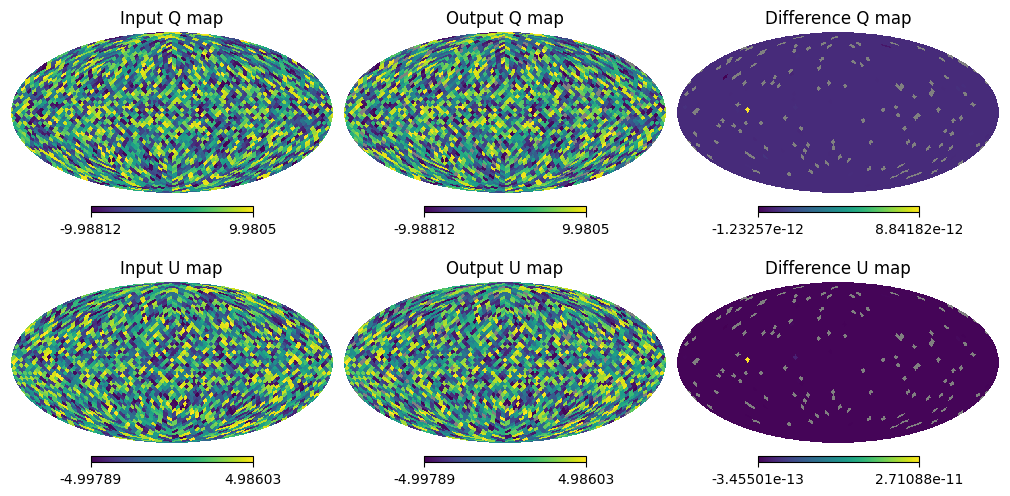

In [10]:
### Plotting and comparing the input and output maps
plt.figure(figsize=(10, 5))

hp.mollview(input_maps[0], sub=231, title="Input Q map")
hp.mollview(gls_result.GLS_maps[0], sub=232, title="Output Q map")
hp.mollview(input_maps[0] - gls_result.GLS_maps[0], sub=233, title="Difference Q map")

hp.mollview(input_maps[1], sub=234, title="Input U map")
hp.mollview(gls_result.GLS_maps[1], sub=235, title="Output U map")
hp.mollview(input_maps[1] - gls_result.GLS_maps[1], sub=236, title="Difference U map")

### Comments on the result

The gray pixels in the output map indicate the bad pixels excluded from the map-making. These are the same pixels reported during the map-making.